# Imports

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import datasets
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

# Data preprocessing

In [3]:
path = '/content/drive/MyDrive/datasets/playground-series-s3e11/'
df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
result = pd.read_csv(path + 'sample_submission.csv')

In [4]:
df_train.head()

,id,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


In [5]:
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

In [6]:
num_columns = list(df_train.select_dtypes(include=['int','float']).columns)
cat_columns = list(df_train.select_dtypes(include=['object','bool','category']).columns)

num_columns.remove('cost')

print("Number of numerical columns:", len(num_columns))
print("Number of categorical columns:", len(cat_columns))
print("Total number of columns in the feature dataframe:", df_train.shape[1])

Number of numerical columns: 15
Number of categorical columns: 0
Total number of columns in the feature dataframe: 16


In [7]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
df_summary = pd.DataFrame(columns=['FEATURE', 'UNIQUE', 'UNIQUE_SHARE', 'ZEROS', 'ZEROS_SHARE', 'NAN', 'NAN_SHARE'])
df_summary

for column in df:
  df_summary = df_summary.append({'FEATURE': column,
                                  'UNIQUE': df[column].nunique(),
                                  'UNIQUE_SHARE': round(df[column].nunique()/df.shape[0], 2),
                                  'ZEROS': df[column].isin([0]).sum(),
                                  'ZEROS_SHARE': round(df[column].isin([0]).sum()/df.shape[0], 2),
                                  'NAN': df[column].isna().sum(),
                                  'NAN_SHARE': round(df[column].isna().sum()/df.shape[0], 2)}, ignore_index=True)

In [ ]:
df_summary

In [8]:
summary(df_train[num_columns])

data shape: (360336, 15)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
store_sales(in millions),float64,0,0.0,1044,0.51,22.92,8.61,5.00,14.08
unit_sales(in millions),float64,0,0.0,6,1.00,6.00,3.00,2.00,4.00
total_children,float64,0,0.0,6,0.00,5.00,2.00,4.00,0.00
num_children_at_home,float64,0,0.0,6,0.00,5.00,2.00,0.00,0.00
avg_cars_at home(approx).1,float64,0,0.0,5,0.00,4.00,2.00,3.00,3.00
gross_weight,float64,0,0.0,384,6.00,21.90,10.30,6.66,21.30
recyclable_package,float64,0,0.0,2,0.00,1.00,1.00,1.00,1.00
low_fat,float64,0,0.0,2,0.00,1.00,0.00,0.00,0.00
units_per_case,float64,0,0.0,36,1.00,36.00,32.00,1.00,26.00
store_sqft,float64,0,0.0,20,20319.00,39696.00,36509.00,28206.00,21215.00


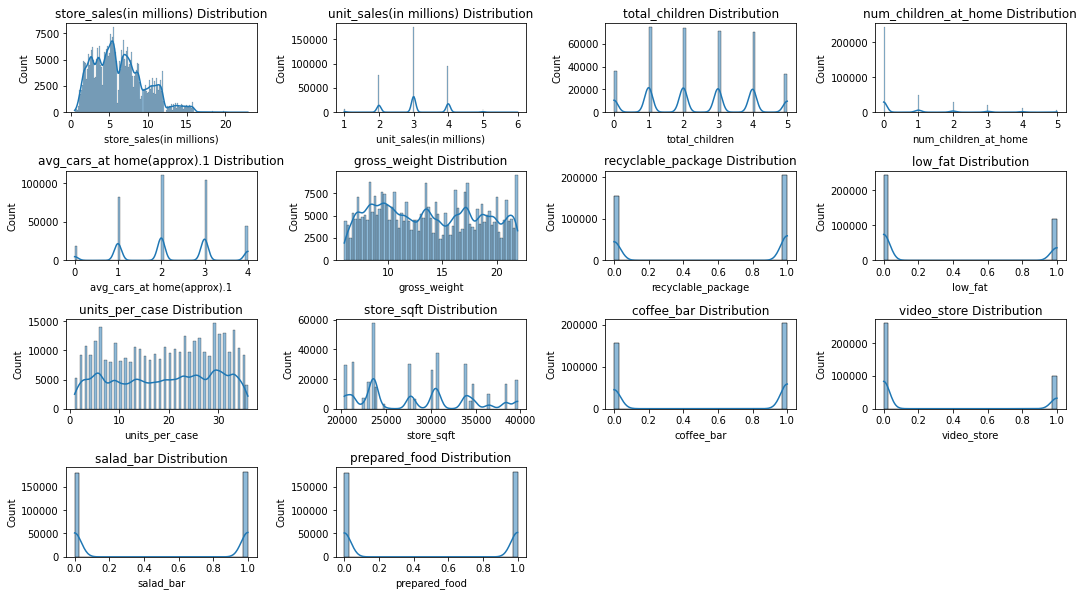

In [9]:
plt.figure(figsize=(15,10))
for id,column in enumerate(num_columns[:-1]):
    plt.subplot(5,4,id+1)
    sns.histplot(x=column,data=df_train, kde=True, palette="Set1")
    plt.title(f"{column} Distribution")
    plt.tight_layout()

In [10]:
scaler = StandardScaler()
df_train[num_columns] = scaler.fit_transform(df_train[num_columns])
df_test[num_columns] = scaler.fit_transform(df_test[num_columns])

## Features selection

In [11]:
X = df_train.drop(columns = ['cost'], axis = 1)
y = df_train['cost']

rfe = RFECV(estimator = XGBRegressor(tree_method = 'gpu_hist', max_depth = 7, 
                           n_estimators = 800, learning_rate = 0.01), min_features_to_select = 2, cv = 5).fit(X, y)

print(X.columns[rfe.support_])

KeyboardInterrupt: ignored

# Training

In [12]:
X = df_train[['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
           'store_sqft', 'coffee_bar', 'video_store', 'prepared_food', 'florist']]

y = df_train['cost']

test = df_test[['total_children', 'num_children_at_home', 'avg_cars_at home(approx).1',
               'store_sqft', 'coffee_bar', 'video_store', 'prepared_food', 'florist']]
# y = np.log(y)

## Catboost

In [13]:
cat_model = CatBoostRegressor()

cat_parameters = {'learning_rate': [0.03, 0.1],
                  'iterations': [50, 100, 300, 500, 1000],
                  'depth': [4, 6, 10], 
                  'l2_leaf_reg': [0.5, 1, 3, 5, 7, 9],
}

cat_grid = RandomizedSearchCV(estimator=cat_model, 
                             param_distributions = cat_parameters,
                             cv = 5, 
                             n_jobs=5,)

cat_grid.fit(X, y, silent=True)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f9bac3a7cd0>,
                   n_jobs=5,
                   param_distributions={'depth': [4, 6, 10],
                                        'iterations': [50, 100, 300, 500, 1000],
                                        'l2_leaf_reg': [0.5, 1, 3, 5, 7, 9],
                                        'learning_rate': [0.03, 0.1]})

In [15]:
cat_parameters_best = cat_grid.best_params_
print(cat_grid.best_params_)

{'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}


In [16]:
cat_model_best = CatBoostRegressor(**cat_grid.best_params_)

cat_model_best.fit(X, y, silent=True)

pred_cat = cat_model_best.predict(test)

## XGBoost

In [18]:
xgb_model = XGBRegressor(tree_method = 'gpu_hist', )

xgb_parameters = {'nthread':[4],
                  'learning_rate': [0.05, 0.1],
                  'max_depth': [4, 6, 8],
                  'min_child_weight': [5, 11, 20],
                  'n_estimators': [50, 100, 300, 500, 1000],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
}


xgb_grid = RandomizedSearchCV(estimator=xgb_model, 
                             param_distributions = xgb_parameters,
                             cv = 5, 
                             n_jobs=5)

xgb_grid.fit(X, y)

[19:40:39] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_jobs=5,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'min_child_weight': [5, 11, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000],
                                        'nthread': [4]})

In [19]:
xgb_parameters_best = xgb_grid.best_params_
print(xgb_grid.best_params_)

{'nthread': 4, 'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_child_weight': 11, 'max_depth': 8, 'learning_rate': 0.05}


In [21]:
xgb_model_best = XGBRegressor(**xgb_parameters_best)

xgb_model_best.fit(X, y)

pred_xgb = xgb_model_best.predict(test)

[19:41:16] WARNING: ../src/learner.cc:767: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.



# Submission

In [ ]:
# pred_xgb = np.exp(pred_xgb)
# pred_cat = np.exp(pred_cat)

In [26]:
result['cost'] = (0.5 * pred_xgb + 0.5 * pred_cat)
result.to_csv('submission.csv', index=False)